# Package Installation and Data Loading

In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install gudhi

In [2]:
import pandas as pd
import numpy as np
import ripser
from persim import plot_diagrams
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.cluster import DBSCAN
import gudhi as gd
import gudhi.representations
import math
import itertools

# Experimenting with Randomized Synthetic Network

## Barcode Diagrams

In [3]:
## This is a customized function I wrote to plot the barcode specifically for Ripser package Persistence Diagrams
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

## Creating a Randomized PPI Network 

In [4]:
## RANDOMIZED Network construction based on a given edge presence probability

# Initializing empty graph with the Networkx Package
protein_network = nx.Graph()

# Adding 100 proteins as nodes
proteins = [f"Protein_{i}" for i in range(1, 101)]
protein_network.add_nodes_from(proteins)

# Adding some randomization by assigning a probability parameter for edge creation
edge_probability = 0.20

# Assigning random weights to edges with given probability
for i, protein1 in enumerate(proteins):
    for j, protein2 in enumerate(proteins):
        if i < j and random.random() < edge_probability:  # Ensuring to add only one side of the edge to avoid duplicates and self-loops
            # Assigning random weights for edges
            protein_network.add_edge(protein1, protein2, weight=random.uniform(0, 0.7))


In [5]:
# Creating protein complexes (connecting nodes within complexes with higher weights)
complex_1 = random.sample(proteins, 10)
complex_2 = random.sample(proteins, 7)
complex_3 = random.sample(proteins, 5)

# Assigning higher weights to edges between proteins that belong in the complexes
for complex_proteins in [complex_1, complex_2, complex_3]:
    for i in range(len(complex_proteins)):
        for j in range(i+1, len(complex_proteins)):
            if protein_network.has_edge(complex_proteins[i], complex_proteins[j]):
                ## For each protein belonging to a complex double the edge weight to indicate stronger interaction
                if protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] >= 0.5:
                    protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] = 0.95
                else:
                    protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] *= 2  

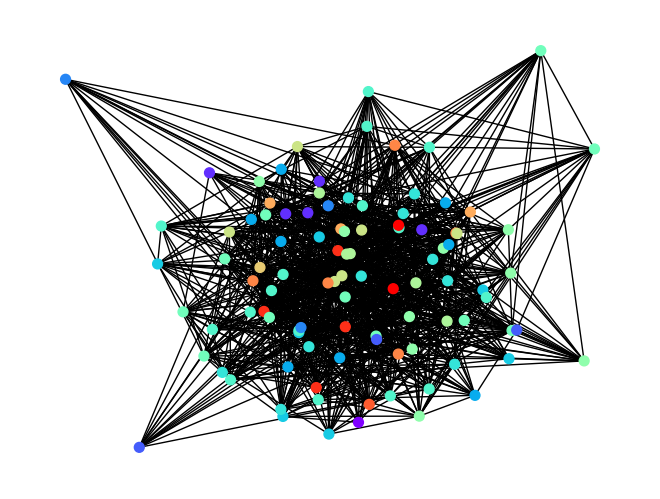

In [6]:
scaled_degree = [d[1]*50 for d in nx.degree(protein_network)]
nx.draw_kamada_kawai(protein_network,
        # Weights Based on Column
        width=list(nx.get_edge_attributes(protein_network, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

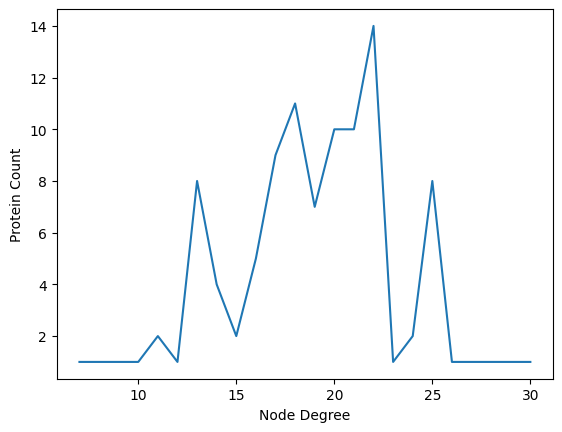

In [6]:
## Node Degree Viualization
## The following is just to check the distribution of the node degrees. As it seems like there are highly central nodes
degree_nodes = {}
for p, d in protein_network.degree():
  degree_nodes[p] = d

## This gives that there are nodes with degree > 900
sorted_node_degrees = dict(sorted(degree_nodes.items(), key=lambda item: item[1],  reverse=True))

## Let's visualize the distribution
viz_degree = {degree: 0 for degree in degree_nodes.values()}
for degree in degree_nodes.values():
  viz_degree[degree]+=1
degree_count_pairs = sorted(viz_degree.items())
x, y = zip(*degree_count_pairs) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel('Node Degree')
plt.ylabel('Protein Count')
plt.show()

# Applying Persistent Homology


**ripser** package was very useful when analysing networks relying solely on a distance matrix of shortest paths for each node pairs (Floyd-Warshall). It does not allow much flexibility when exploring filtrations set to edge weights.

## Using the Adjacency Matrix

In [7]:
## Extract the adjacency matrix from the NetworkX package and fill the diagonal to indicate node self-connection
pn_adjacency = nx.adjacency_matrix(protein_network).toarray()
np.fill_diagonal(pn_adjacency, 1)

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


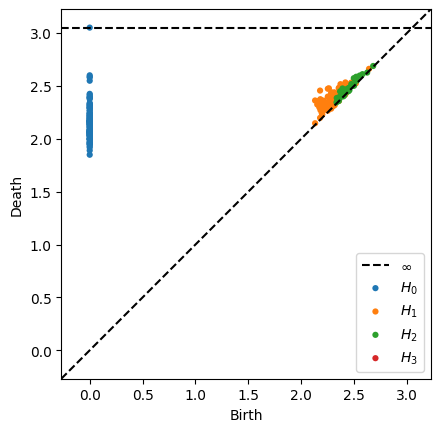

In [6]:
## Run the Vietoris-Rips filtrations on the adjacency matrix (maximum homology dimension is set to 3)
## This would not make too much sense as we should be feeding a distance measure between the nodes. Although we have a square matrix we are not on a metric space.
pn_diagrams = ripser.ripser(pn_adjacency, distance_matrix=False, maxdim=3)['dgms']
plot_diagrams(pn_diagrams)

In [ ]:
## Exploring the Barcode Diagrams for the two Homology ranks 0 and 1
## H_0
plot_barcode(pn_diagrams, 0)
## H_1  
plot_barcode(pn_diagrams, 1)
## H_2
plot_barcode(pn_diagrams, 2)
## H_3
plot_barcode(pn_diagrams, 3)

## Using Floyd-Warshall Pair Distances Matrix

In [7]:
## Switching to a metric space through node-pair distances. We use the Floyd-Warshall algorithm.
pn_FW_distance = np.array(nx.floyd_warshall_numpy(protein_network))

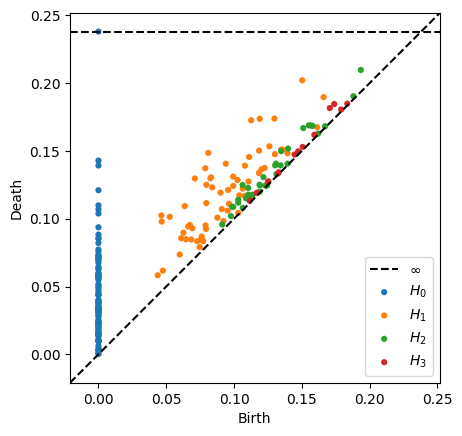

In [8]:
## Applying Rips filtration should work with a distance matrix, as such the diagrams make more sense.
pn_FW_mat_diagrams = ripser.ripser(pn_FW_distance, distance_matrix=True, maxdim=3)['dgms']
plot_diagrams(pn_FW_mat_diagrams)

In [ ]:
## Exploring the Barcode Diagrams for the different Homology ranks
## H_0
plot_barcode(pn_FW_mat_diagrams, 0)
## H_1  
plot_barcode(pn_FW_mat_diagrams, 1)
## H_2
plot_barcode(pn_FW_mat_diagrams, 2)
## H_3
plot_barcode(pn_FW_mat_diagrams, 3)

## Using Correlation Distance Matrix

In [8]:
## The reasoning here is that if the score value for the proteins measures semantic similarity, converting it 
##to a dissimilarity measure would be a distance measure. as such protein-pairs with low scores would be "closer" to eachother.
np.fill_diagonal(pn_adjacency, 1)
pn_distance_mat = 1 - pn_adjacency

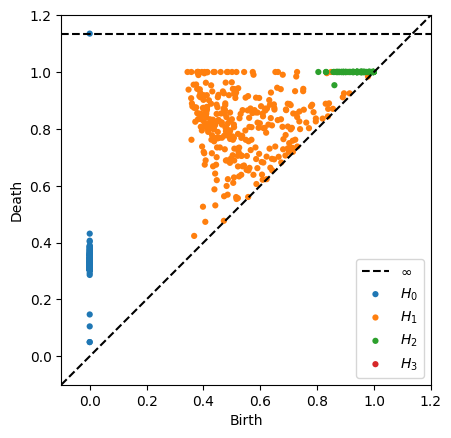

In [12]:
dist_mat_diags_ripser = ripser.ripser(pn_distance_mat, distance_matrix=True, maxdim=3)['dgms']
plot_diagrams(dist_mat_diags_ripser)

In [ ]:
plot_diagrams(dist_mat_diags_ripser, plot_only=[0])
plot_barcode(dist_mat_diags_ripser, 0)

In [ ]:
plot_diagrams(dist_mat_diags_ripser, plot_only=[1])
plot_barcode(dist_mat_diags_ripser, 1)

In [ ]:
plot_diagrams(dist_mat_diags_ripser, plot_only=[2])
plot_barcode(dist_mat_diags_ripser, 2)

## GUDHI Persistent Homology Analysis and Clustering

### Simplex Tree Construction

In [12]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(proteins)}

In [20]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_network.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['weight'])



### Persistent Homology

In [ ]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

persistence = simplex_tree.persistence(min_persistence=0, persistence_dim_max=False)

# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence)
barcode = gd.plot_persistence_barcode(persistence)
density = gd.plot_persistence_density(persistence)


### Exploring Simplices in Simplex Tree

In [22]:
smplx_tree_gen = simplex_tree.get_filtration()

In [ ]:
for smplx in smplx_tree_gen:
    if(len(smplx[0]) == 1):
        print(smplx)

#if len(smplx[0] == 1):

In [24]:
simplex_tree.dimension()

1

In [25]:
simplex_tree.num_simplices()

1089

In [26]:
simplex_tree.num_vertices()

100

### Feature Extraction and Clustering

In [27]:
## death values of np.inf would not give us a measure to cluster them with DBSCAN, so let's set a cap death time for those to a max value of 1
for i, pt in enumerate(persistence):
    if pt[1][1] == np.inf:
        pt = list(pt)
        pt[1] = list(pt[1])
        pt[1][1] = 1
        pt[1] = tuple(pt[1])
        persistence[i] = tuple(pt)
        #print(pt)

In [28]:

# Extract features from the persistence diagrams
# I will use just the birth and death times of the topological features for now and see how DBSCAN would perfrom in the clustering
features = np.array([[pt[1][0], pt[1][1]] for pt in persistence])


# Cluster the proteins into complexes using DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(features)

# Get the predicted labels (complexes)
predicted_labels = dbscan.labels_


In [29]:
## TESTING 
predicted_labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
# Print predicted complexes
complexes = {}
for i, protein in enumerate(proteins):
    label = predicted_labels[i]
    if label not in complexes:
        complexes[label] = []
    complexes[label].append(protein)

print("Predicted complexes:")
for label, members in complexes.items():
    print(f"Complex {label}: {', '.join(members)}")

In [ ]:
print(len(complex_1))
print(complex_1)

In [ ]:
print(len(complex_2))
print(complex_2)

In [ ]:
print(len(complex_3))
print(complex_3)

### DBSCAN Parameter Estimation

In [ ]:
x = []
for pt in persistence:
    x.append(list(pt[1]))
x

In [ ]:
# Calculate k-nearest neighbors epsilon-distances 
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i][0] - X[j][0]) ** 2) +
                    ((X[i][1] - X[j][1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

In [ ]:
## Plot eps_distances
eps_dist = calculate_kn_distance(x,3)
plt.hist(eps_dist,bins=100)
plt.ylabel('n');
plt.xlabel('Epsilon distance');


## GUDHI RipsComplex Construction

In [16]:
## Here we use the Gudhi library to build the Rips complex and apply the homology.
## We can build the Rips simplicial complex by using a distance matrix. So I just plugged in the correlation distance matrix.
rips_complex = gd.RipsComplex(distance_matrix=pn_distance_mat, max_edge_length=1.0)


## We now build a simplex tree to store the simplices
rips_simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)


## Check how the complex looks like
result_str = 'Rips complex is of dimension ' + repr(rips_simplex_tree.dimension()) + ' - ' + \
    repr(rips_simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(rips_simplex_tree.num_vertices()) + ' vertices.'

print(result_str)

Rips complex is of dimension 3 - 4087975 simplices - 100 vertices.


In [10]:
persistence = rips_simplex_tree.persistence(min_persistence=-1, persistence_dim_max=True)

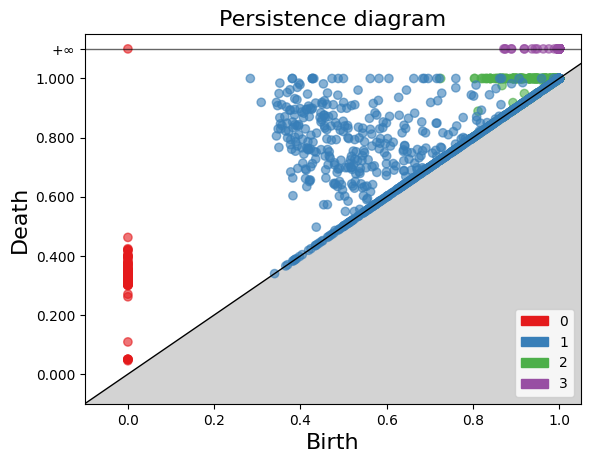

In [36]:
# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence, max_intervals=4000000)


In [ ]:
for pt in persistence:
    if pt[0] == 3 and pt[1][0] < 0.9:
        print(pt)

In [ ]:
for filtered_value in rips_simplex_tree.get_filtration():
    if len(filtered_value[0]) == 3 and filtered_value[1] < 0.5:
        print(filtered_value)

In [72]:
rips_smplx_combs = list(itertools.combinations(complex_3, 3))

In [89]:
idx_rips_smplx_combs = []
for comb in rips_smplx_combs:
    tmp = []
    for protein in comb:
        tmp.append(int(protein.strip("Protein_"))-1)
    idx_rips_smplx_combs.append(tmp)

In [74]:
rips_smplx_perms = list(itertools.permutations(complex_3, 3))

In [90]:
idx_rips_smplx_perms = []
for comb in rips_smplx_perms:
    tmp = []
    for protein in comb:
        tmp.append(int(protein.strip("Protein_"))-1)
    idx_rips_smplx_perms.append(tmp)

In [76]:
len(idx_rips_smplx_combs)

10

In [77]:
len(idx_rips_smplx_perms)

60

In [91]:
for filtered_value in rips_simplex_tree.get_filtration():
    if len(filtered_value[0]) == 3:
        if filtered_value[0] in idx_rips_smplx_perms:
            print(filtered_value)

([23, 26, 49], 1.0)
([23, 26, 52], 1.0)
([23, 49, 52], 1.0)
([26, 49, 52], 1.0)
([23, 26, 81], 1.0)
([23, 49, 81], 1.0)
([26, 49, 81], 1.0)
([23, 52, 81], 1.0)
([26, 52, 81], 1.0)
([49, 52, 81], 1.0)


In [80]:
rips_smplx_pers_intervals_dim2 = rips_simplex_tree.persistence_intervals_in_dimension(2)

In [81]:
relevant_filtrations = []
for interval in rips_smplx_pers_intervals_dim2:
    if interval[1] - interval[0] > 0.15:
        print(interval)
        relevant_filtrations.append(interval[0])

[0.72513308 1.        ]
[0.83226336 1.        ]
[0.80335571 1.        ]
[0.84000621 1.        ]
[0.83933016 1.        ]
[0.80438672 1.        ]
[0.84101058 1.        ]
[0.84101058 1.        ]
[0.83189731 1.        ]
[0.82205069 1.        ]
[0.84950464 1.        ]
[0.81910999 1.        ]
[0.82712267 1.        ]


In [ ]:
persistent_simplicial_cmplxs = []
for filtered_value in rips_simplex_tree.get_filtration():
    if len(filtered_value[0]) == 3 and filtered_value[1] in relevant_filtrations:
        print(filtered_value)
        persistent_simplicial_cmplxs.append(filtered_value)

In [66]:
len(persistent_simplicial_cmplxs)

42

In [92]:
print(complex_1)
print(complex_2)
print(complex_3)

['Protein_64', 'Protein_20', 'Protein_81', 'Protein_10', 'Protein_86', 'Protein_88', 'Protein_63', 'Protein_90', 'Protein_93', 'Protein_4']
['Protein_15', 'Protein_57', 'Protein_48', 'Protein_4', 'Protein_56', 'Protein_63', 'Protein_24']
['Protein_50', 'Protein_27', 'Protein_53', 'Protein_24', 'Protein_82']


In [96]:
for protein in complex_3:
        print(int(protein.strip("Protein_"))-1, end = ' ')

49 26 52 23 81 

In [93]:
rips_smplx_pairs = rips_simplex_tree.persistence_pairs()

In [97]:
for pers_pair in rips_smplx_pairs:
    if len(pers_pair[0]) == 3:
        if pers_pair[0] in idx_rips_smplx_perms:
            print(pers_pair)

([49, 26, 23], [49, 26, 23, 0])
([52, 26, 23], [52, 26, 23, 0])
([52, 49, 23], [52, 49, 23, 0])
([52, 49, 26], [52, 49, 26, 0])
([81, 26, 23], [81, 26, 23, 0])
([81, 49, 23], [81, 49, 23, 0])
([81, 49, 26], [81, 49, 26, 0])
([81, 52, 23], [81, 52, 23, 0])
([81, 52, 26], [81, 52, 26, 0])
([81, 52, 49], [81, 52, 49, 0])


## Persistence Landscapes

In [13]:
rips_LS_dim0 = gd.representations.Landscape().fit_transform([dist_mat_diags_ripser[0]])

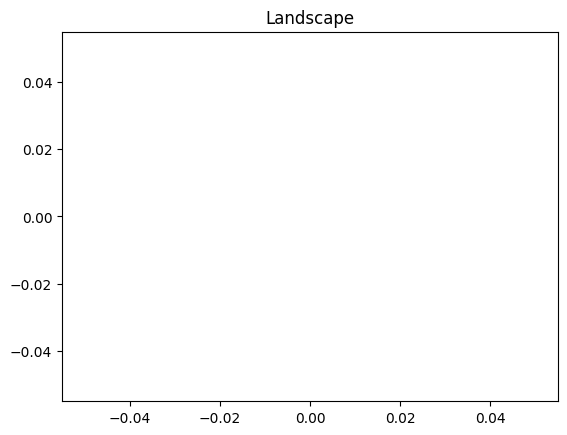

In [18]:
plt.plot(rips_LS_dim0[0][:100])
plt.plot(rips_LS_dim0[0][100:200])
plt.plot(rips_LS_dim0[0][200:300])
plt.plot(rips_LS_dim0[0][300:400])
plt.plot(rips_LS_dim0[0][400:500])
plt.title("Landscape")
plt.show()

In [19]:
rips_LS_dim1 = gd.representations.Landscape(num_landscapes=5).fit_transform([dist_mat_diags_ripser[1]])

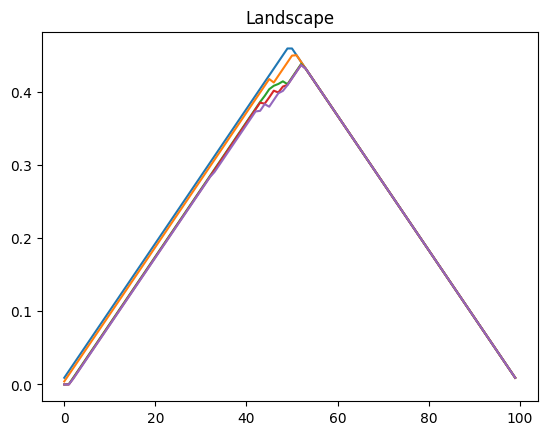

In [21]:
plt.plot(rips_LS_dim1[0][:100])
plt.plot(rips_LS_dim1[0][100:200])
plt.plot(rips_LS_dim1[0][200:300])
plt.plot(rips_LS_dim1[0][300:400])
plt.plot(rips_LS_dim1[0][400:500])
plt.title("Landscape")
plt.show()

In [23]:
rips_LS_dim2 = gd.representations.Landscape().fit_transform([dist_mat_diags_ripser[2]])

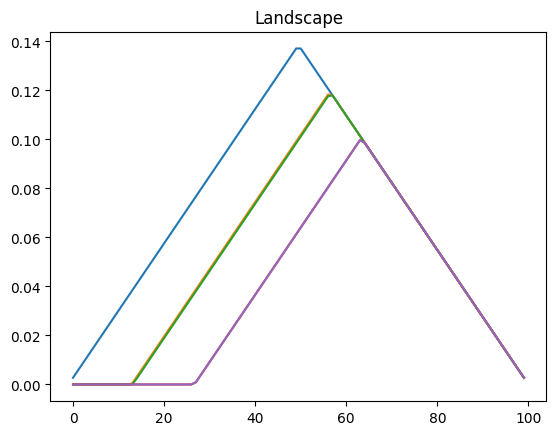

In [24]:
plt.plot(rips_LS_dim2[0][:100])
plt.plot(rips_LS_dim2[0][100:200])
plt.plot(rips_LS_dim2[0][200:300])
plt.plot(rips_LS_dim2[0][300:400])
plt.plot(rips_LS_dim2[0][400:500])
plt.title("Landscape")
plt.show()

## Persistence Image

In [158]:
pi = gd.representations.PersistenceImage(bandwidth=1e-2, weight=lambda x: x[1]**2, resolution=[500,500])

In [159]:
rips_cmplx_pers_img  = pi.fit_transform([dist_mat_diags_ripser[1]])

In [ ]:
for pt in dist_mat_diags_ripser[1]:
    if pt[1] == np.inf:
        pt[1] = 1
    print(pt)

In [157]:
len(rips_cmplx_pers_img[0])

160000

In [ ]:
plt.imshow(np.flip(np.reshape(rips_cmplx_pers_img[0], [500,500]), 0))
plt.title("Persistence Image Dim 1")